<h1><b> DSC 170: Lecture 3. Advanced Geopandas (Geopandas - 2) </b></h1>

This second Geopandas notebook will demonstrate accessing and analyzing spatial data from different sources,as well as  projections and vector operations, including:
- constructing a geodataframe from scratch
- computing distance, buffers, etc.
- spatial join

We will also look at several key data sources, for San Diego and California, and work with several real datasets.

We also have a forensic story behind this notebook: we'll try to reconstruct spatial relationships between different features in a geodataframe - when they are far from obvious.



## Importing geopandas

Note that you need %matplotlib inline to show maps


In [ ]:
%matplotlib inline 
import geopandas # to be able to work with map data
import pandas as pd

# it's always a good idea to figure out the current directory, and the software version
import os
current_dir = os.getcwd()
print(current_dir)
geopandas.__version__

In [ ]:
# set data location (uncomment one of them)
data_location = os.environ["HOME"]+"/public/datasets/"  # in the shared datahub 
# We recommend that you use this location if you run your notebooks with the pre-built class datasets.


# data_location = "../../8. Data/"    # on my local install (this is what I use when I debug the code)

## Explore real datasets

There are lots of spatial data available online, from federal, state and local agencies,  from companies, university projects, and idividual enthusiasts.

A good source of data for San Diego is http://sandag.org. Follow this link and click "Maps and GIS" on the left side, then "GIS Data Downloads" - "Regional GIS Data Warehouse". __*Create an account*__  and explore 270 spatial data layers available for San Diego.  This is a good example of a local (county-wide) spatial data warehouse, with integrated online mapping.

Spatial data for California can be retrieved from CA data portal (http://data.ca.gov), CA GIS portal (https://gis.data.ca.gov/search), or https://mapcruzin.com/free-united-states-shapefiles/free-california-arcgis-maps-shapefiles.htm. There are many other sources as well.

You may also consult various library guides, eg http://libguides.humboldt.edu/c.php?g=303789&p=2026238,  https://ucsd.libguides.com/data-statistics/frequentlyuseddata 

For US-wide data, see http://data.gov. Many datasets are available as GeoJSON or shapefiles.

__When you work with external data sources, make sure you understand how the data were compiled! This is very important, because it will help you understand how accurate and current the data is, whether the data compilation methodology and accuracy  are uniform across the dataset, and other properties that may limit its use for analysis.__

### Download shapefiles and read them into geodataframe

From SanDAG, we'll grab a layer of **parks**. Navigate to Parks in the Regional GIS Data Warehouse, download both the Parks shapefile (as a zip archive) and metadata for this shapefile (as a pdf.)

Note this phrase in Parks metadata: 
<code>
This dataset was created by merging parks datasets from the following sources: County of San Diego, City of San Diego, San Diego Port District, State Parks, SanGIS and 16 other incorporated cities in San Diego County.</code>

It's unclear if the data were compiled in a uniform manner by all the contributing municipalities or agencies, or if SanDAG worked on unifying the data besides merging (e.g., along the municipal boundaries, where conflicts are likely.)

From mapcruzin.com, we'll get CA Coastline and CA Water shapefiles. Notice that the shapefiles include a .prj (which is great!) but no other metadata. At least, with the .prj information we know what the numbers in the geometry column mean. 

Typically, data layers served by government agencies have well-constructed metadata, which follow a common standard for metadata descriptions. Not always the case with other data (e.g., from mapcruzin.)



In [ ]:
# Read the shapefiles into respective geodataframes, and 
# explore them using .head, .tail, .info, or any other technique you prefer

# Then, run  .plot() or .explore() to create a map

shpFileIn = data_location +'sandiego/parks/PARKS.shp'
sd_parks = geopandas.read_file(shpFileIn)
sd_parks.tail(50)



#### Which operation would we use if we want to aggregate this dataset by park names?

Remember that Dissolve for spatial data is similar to Group By. 
Also remember from the previous lecture that spatial information could be derived in different ways. It is likely that boundaries of parks have been delineated from imagery as areas with green vegetation. Then they were converted to vector polygons, and each polygon received a label and attributes (name, ownership, etc.) This means that one park may appear as multiple polygon records. 

In data science projects, we often work with records for individual named objects (eg, it is more likely to find data about visitors to each park than about visitors to each of these polygons). You use DISSOLVE to transition from how spatial data are typically presented, to how data scientists work with data (e.g., in pandas.)


In [ ]:
# Example how you can query and subset records here, to show a single park by name (typical pandas, should be no surprises)
cols = ['geometry','NAME','OWNERSHIP']

a = sd_parks[cols]
a[a['NAME'] == 'All Seasons Park']

In [ ]:
# Another example how we can show multiple polygons for a single named park/open space

print(sd_parks.loc[sd_parks['NAME'] == 'CARMEL VALLEY OS'])

# There are 93 polygons or multpolygons representing "Carmel Valley Open Space":
print(sd_parks.loc[sd_parks['NAME'] == 'CARMEL VALLEY OS'].shape)

In [ ]:
# We can see them on a map
sd_parks.loc[sd_parks['NAME'] == 'CARMEL VALLEY OS'].plot()



In [ ]:
# or, using the explore functionality in Geopandas:
import folium

# below, all parks are plotted underneath "Carmel Valley OS", and map extent is set to all parks
map = sd_parks.explore(popup=True)
map.add_child(folium.Choropleth(geo_data=sd_parks.loc[sd_parks['NAME'] == 'CARMEL VALLEY OS'],fill_color="Red",fill_opacity=0.3))
map


In [ ]:
# Now, let's experiment with DISSOLVE to aggregate such records into multi-polygons


cols = ['geometry','NAME','OWNERSHIP']
sd_parks_dissolved = sd_parks[cols].dissolve(by='NAME', aggfunc = 'first', as_index=False)
sd_parks_dissolved.plot(figsize=(20,20), column = 'NAME')
print(sd_parks_dissolved.shape)

# Notice that you need to specify the column on which you do the DISSOLVE, and a function to apply to other columns in the dataframe 
# In this case, we just keep the NAME. 

# If aggregating by area, we would use "sum", or "max", depending on the purpose

In [ ]:
sd_parks_dissolved.geom_type

# Notice the many "multipolygon" types here because DISSOLVE aggregated multiple polygons based on common NAME

# Also recall, from the Parks metadata, that the layer is aggregated from data provided by 
# individual municipalities and agencies; then these were organized into a single layer by SanDAG
# 
# This means that we can expect inconsistencies across the entire map layer (in precision/point density). 
# They are especailly likely to be visible along municipal boundaries 

In [ ]:
# Let's plot the parks data we just loaded
sd_parks.plot(figsize=(10,10), column = 'OWNERSHIP', legend = True)



In [ ]:
# alternatively:

sd_parks.explore(column='OWNERSHIP',legend=True, width="80%", categorical=True,tiles = "CartoDB dark_matter")


**Explore this map carefully.**

    1) Observe park boundaries in the eastern part of the county. What do they tell you about how these data were constructed? 
    2) Zoom in to Coronado or San Diego downtown and observe park boundaries here. Why do these boundaries look different? How were they constructed? 
    3) What does this tell you about spatial accuracy of the data? 
    4) What other abnormalities have you noticed? 
    5) How would these issues affect spatial analysis? What kinds of applications would be affected?


### Let's load the two other datasets we got from mapcruzin.com:  Water objects, and California coastline

They have been preloaded in the "data" directory, 


In [ ]:
shpFileIn = data_location + 'california/water/california_water.shp'
ca_water = geopandas.read_file(shpFileIn)
ca_water.info

In [ ]:
ca_water.plot(figsize=(10,10), column = 'NATURAL', legend = True)
ca_water.count()

Notice that not all water bodies have a name

**How was this map constructed - what do you think?**

    - Most likely, the source was water bodies identified in satellite imagery (we'll look at how in the "raster" part of the class).
    - Then, the analyst gave names to those water bodies that had names.

But most water bodies remained unnamed, as the dataframe showed.

In [ ]:
# now the same for the coastline data

shpFileIn = data_location + 'california/coastline/california_coastline.shp'
ca_coastline = geopandas.read_file(shpFileIn)
ca_coastline.info

In [ ]:
ca_map = ca_coastline.plot(figsize=(10,10))

In [ ]:
# Let's create a single map showing several themes: coastline, water objects, and SD parks
# Recall how we combined several layers in the previous lecture: first you draw a basemap (eg coastline, 
# in our case), then add other layer plots to it. 

ca_map = ca_coastline.plot(figsize=(10,10))
ca_water.plot(ax=ca_map, column = 'NATURAL');

In [ ]:
# in the same fashion, add sd_parks as another layer:

ca_map = ca_coastline.plot(figsize=(10,10))
sd_parks.plot(ax=ca_map, column = 'OWNERSHIP')
ca_map.set_title("SD Parks")      

# you can set a map title and several other common map elements, but graphic capabilities here are limited

### Why don't we see both the coastline and the parks??




 - Recall that when we displayed the content of the geodataframes, coordinates in the sd_parks layer were represented with really large numbers - unlike coordinates in the other two datasets

 - But geopandas plot() doesn't know what these numbers mean! This map shows all these three geodataframes, but water bodies and coastline are shown as a dot near the (0,0) point


**Because coordinate reference systems of these geodataframes are different!**


In [ ]:
# let's check the coordinate reference systems (crs) of the three GDFs

print(ca_water.crs)
print(ca_coastline.crs)
print(sd_parks.crs)

## Coordinate reference systems that you are likely to work with

EPSG (European Petroleum Survey Group) started cataloguing CRSs and giving them standard descriptions and identification numbers. EPSG was later absorbed into IOGP (International Association of Oil & Gas Producers), which maintains the "EPSG Geodetic Parameter Set". The IDs are still known as EPSG codes. 

Note the most widely used coordinate reference systems in our area:

* 4326: WGS84, latitude/longitude, in decimal degrees, used in GPS; covers the world; http://epsg.io/4326, http://spatialreference.org/ref/epsg/4326/. Geographic coordinate system. The default used in most cases by web mapping APIs. You normally use this coord system in KML etc. If a CRS is not specified, and the data are relatively recent, and look like latitude and longitude, there is a good chance it is 4326.

**Explore one or both of the links above. See that each coordinate reference system can be referred to by its epsg code, and presents information about its point of origin, units of measure, datum, spheroid, etc. This information is available in both standard and vendor specific formats. If we are talking about a projected coordinate system, then the description may also contain accuracy of coordinate translation from a geographic coordinate system to the projected one.**

* 2230: California State Plane Zone 6, over NAD83, used for San Diego, with data in feet http://spatialreference.org/ref/epsg/nad83-california-zone-6-ftus/, http://epsg.io/2230. State Plane Coordinate Systems are rectangular plane coord systems used within states (so expect local data in this system). Coordinates are in feet. Most states have several zones.

* 3857: Projected coordinate system used by Google Maps, OpenStreetMap, etc. Use it when need to align with map tiles coming from online map services. Based on WGS84 datum. Also called Web Mercator projection, units are meters (but not uniform). Map servers convert lat/lon to 3857 internally to match with basemap imagery. Also known as EPSG:900913 (earlier and not too official; 900913 came from 'GOOGLE'). Covers up to 85 degrees latitude. https://epsg.io/3857 , https://en.wikipedia.org/wiki/Web_Mercator_projection 

* 26911: UTM Zone 11N, over NAD83;  Topographic mapping. Larger areas; in meters. http://epsg.io/26911. UTM Grid is used in all countries, covers area between 80 degrees N and S. Divided into columns of 6 degrees (zones), numbered from 1 to 60. Each zone has a central meridian, it is assigned 500,000 m Easting (to make sure coordinates are positive numbers). Equator is assigned 0 m Northing for Northern Hemisphere; 10,000,000m Northing for Southern Hemisphere.

WGS84 / epsg:4326 is an example of a __geographic__ coordinate system (the most common one). It is based on a spheroid, and uses angular units (degrees). Latitude measures the distance north or south of the equator, while longitude measures the distance east or west of the prime meridian.

Web Mercator, UTM, State Plane Coordinate System - are examples of a __projected__ coordinate system. A projected coordinate system is a coordinate system that is used to map geographic locations onto a flat surface. It is based on a plane (spheroid projected onto 2D), and uses linear units. There are thousands of projected coordinate systems.

See more at https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/, https://gis.stackexchange.com/questions/182444/understanding-difference-between-coordinate-system-and-projection



Other good reference sites:
* http://mapref.org/
* https://proj4.org/operations/projections/



In [ ]:
# Let's explore the CRS of the sd_parks GDF
sd_parks.crs

# The units are feet (hence the large numbers), from the origin of thie CRS, expressed as Easting and Northing

In [ ]:
# if we want to show the data correctly aligned on one map, we need to reproject so that the coordinate reference systems match

sd_parks2 = sd_parks.to_crs("EPSG:4326")

# These also work:
# sd_parks2 = sd_parks.to_crs(4326)
# sd_parks2 = sd_parks.to_crs(epsg=4326)

# in the recent versions of geopandas re-projection works much faster than before!! 



In [ ]:
sd_parks2.head() 

# notice that polygon coordinates in the geometry column are now different: they are in decimal degrees

In [ ]:
# Now, let's try to construct a multu-layer map again, at least with the coastline and parks

ca_map = ca_coastline.plot(figsize=(10,10))
sd_parks2.plot(ax=ca_map, column = 'OWNERSHIP', legend = True)
ca_map.set_title("SD Parks")

# it now works correctly

In [ ]:
# it would be a good idea, before attempting any geometric operations, to assert that CRS match:
assert ca_coastline.crs == sd_parks.crs, "CRS are different!"
assert ca_coastline.crs == ca_water.crs, "CRS are different!"

In [ ]:
# Folium knows about coordinate systems - see by yourself:
# Everything is projected to the coordinate system of the underlying tiles

map = ca_water.explore(popup=True)
map.add_child(folium.Choropleth(geo_data=sd_parks,fill_color="Red",fill_opacity=0.3))
map

## More about coordinate reference systems  in Geopandas: http://geopandas.org/projections.html

**Also, please see [lecture slides](https://docs.google.com/presentation/d/19LHvGOCfYsOHjw6qgW5X0pFd-QrGjk7C5D9L7OWIjrA/edit?usp=sharing) describing different terms used for coordinate reference systems: geoid, ellipsoid, spheroid, datum, etc., plus different types of projections, and when to use which projections**



### Explore map projections for the world


In [ ]:
naturalearth_lowres = data_location +"world/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = geopandas.read_file(naturalearth_lowres)
world.plot()
print(world.crs)

In [ ]:
# Let's look at the world map in the Web Mercator projection, and then in a couple others
world_m = world.to_crs('epsg:3395')
world_m.plot(figsize=(10,10))

world_m = world.to_crs("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs")
world_m.plot() #Eckert IV (copied from https://epsg.io/54012)

world_m = world.to_crs(" +proj=moll +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs")
world_m.plot() #Mollweide (copied from https://epsg.io/54009)

# Notice that geopandas can refer to CRS by EPSG numbers, and also accept a standard definition of projection from epsg.io

Notice how different the world maps above are!

In the first case (Web Mercator): north is always up; angles are locally correct - this is critical for local navigation (eg in Google Maps). But areas inflate with distance from the equator. Greenland looks bigger than South America (while it is 8 times smaller), and even bigger than Africa (in reality, it is 14 times smaller)

The Eckert IV projection can be used for political mapping, and in other cases when you need to reflect true size of different areas and show global distributions. it is an equal-area projection.

Mollweide is another type of equal-area projection.

If you are interested in specific uses and differences, see https://research.tableau.com/sites/default/files/User%20preference%20for%20world%20map%20projections.pdf 

**You probably noticed that while a projection can keep some of the properties of shapes correct, it can do it at the expense of other properties**

### Tissot's Indicatrix 
... is a way to charactrize local distrotions due to map projection: a geometry that results from projecting a small circle from a globe onto a map. It results in an ellipse; its shape indicates local distortions. Tissot was a 19th century French mathematician.

For the Mercator projection:
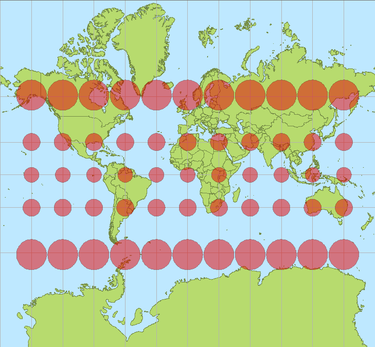

See more examples at https://en.wikipedia.org/wiki/Tissot%27s_indicatrix


### Even more fun with projections? 
See https://xkcd.com/977/ (the best map projection for YOU!)

### How do you choose which coordinate system to use for your map?
If you have more than one gdf in your project, and they use different CRS, which of them you reproject to?

The answer depends on several factors:
- Area of interest and map scale: geographic coordinate systems would work for maps covering larger areas, while projected (UTM, State Plane) would be better for small areas. Scale is related to what CRS properties that  can be preserved, e.g., preserving true distances ("equidistant" projections) doesn't work for world maps
- Accuacy requirements: e.g., if a map is used for high precision surveying, need to have accurate Datum, etc.
- Compatibility with other layers: e.g., if need to overlay on a satellite image, need to convert to the CSR of the image
- Costs of reprojection: Reprojecting a layer with fewer vertices would work faster
- Projection distortions: which map properties you want to preserve and which you can sacrifice (local angles? shapes? size? scale in different parts of the map?)
- Spatial operations you want to perform on the data.

**This last one is critical. So let's look at spatial operations!**
 


## Spatial Operations

Now that we have coordinate information in the geodataframe, we can do spatial operations over it. 

### Simple operations over a single geodataframe

In [ ]:
# These are mostly self-explanatory

# type of geometry (in WKT terms)
print(sd_parks2.geom_type[0])

# spatial extent, or bounding box, or envelope, for the entire set of objects in theGDF
print(sd_parks2.total_bounds)

# same, for the same GDF, in projection 2230
print(sd_parks.total_bounds)

# centroid, for the first object. But notice the warning!!! Geopandas doesn't like to do geometric operations on a geographic CRS! 
print(sd_parks2.centroid[0])

# representative point: a point near a center that is guaranteed to be inside, eg when you need to place a label or point inside a polygon 
print(sd_parks2.representative_point()[0]) 

# area computation: similar concern about doing this over a geographic CRS
print(sd_parks2.area[0]) 
print(sd_parks.area[0])


#### When you expect to perform geometric operations: don't use CRS in decimal degrees!

In [ ]:
# If you want to get the results in a geographic CRS: 
# change to a projected crs first, execute geometric operations, 
# and then reproject back to WGS84 (4326)
# Such warnings is a recent addition to geopandas

print(sd_parks.crs) # this is a projected crs
pnt = sd_parks.centroid
print(pnt.to_crs(4326))

### Computing distance between spatial objects, and exploring spatial relationships

There are two options when computing distance (or other relationships): 

1. your objects are in two different geodataframes (or geoseries): sd_parks2.distance(ca_water) will return distances beetween each park and objects in ca_water 

1. your objects are in the same dataframe, and you need to compute distances between pairs of objects: use shift()... if it makes sense (i.e., if the records are arranged in some meaningful order.)

### A key convention in GIS: distance between spatial features is the “shortest separation between features” not between their centers

In [ ]:
# example of the first option:

# let's figure out the ID of Lake Hodges, then compute distances from the first 3 parks to this lake
print(ca_water[ca_water['NAME'] == 'Lake Hodges'])

for i in range(3):
    
#     the format is: gdf1.distance(object_in_gdf2)
    
    print(sd_parks2.distance(ca_water.loc[7108,'geometry'])[i], sd_parks2.loc[i,'NAME'])
    
    
#      Question: What are the units of distance here??

In [ ]:
# the above is likely incorrect...

# let's get some projected CRS for CA, eg from http://epsg.io/?q=California%20kind%3APROJCRS
# for example, NAD83 / California Albers (epsg:3310). 
# See justification at https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline


ca_water_3310 = ca_water.to_crs(3310)
sd_parks_3310 = sd_parks.to_crs(3310)
for i in range(3):
    print(sd_parks_3310.distance(ca_water_3310.loc[7108,'geometry'])[i], sd_parks_3310.loc[i,'NAME'])


In [ ]:
# IF records are arranged in some meaningful order, one can use shift() to compute distance between neighbors. 
# This is an example of the second option. 

# let's create a subset of the gdf, with 10 parks:
sd_parks_dis = sd_parks_3310[0:10]
sd_parks_dis


In [ ]:
# then compute distance between parks 0 and 1, 1 and 2, ...

dis = sd_parks_dis.distance(sd_parks_dis.shift())
dis

# not quite sure why it gives a warning here...

notice that there is 0 distance between parks 2 and 3. Maybe they are next to each other? Adjacent, in other words?



### Adjacency is another spatial relationship that is often needed in applications

In [ ]:
# Adjacency is a common property that can be analyzed with Geopandas.
# Let's check if there are adjacent parks in the sequence of the first 10 parks:
adjacent = sd_parks_dis.touches(sd_parks_dis.shift())
adjacent

# hmmm, none of them are adjacent. 
# We'll do some additional forensic analysis at the end of the notebook, 
# after we explore binary predicates in more detail

 ### The general format of binary predicates:
 
Adjacency is a condition that can be checked using a boolean function that takes two geometric objects as input and returns a true or false value based on the spatial relationship "touches". Such boolean functions are called **binary spatial predicates**.

GeoSeries.topological_condition(other geoseries)   --> returns True or False
 
Binary spatial predicates check for several types of topological relationships. They are constructed from relationships between boundaries and interiors of objects. 

These topological operations can be:
 
* __touches__ (interiors don't intersect, but have at least one point in common)
* __within__ (or completely within: object boundaries don't touch, and both boundary and interior of one object is within another). 
* __contains__ (object's interior contains boundary and interior of the other object; it is inverse of the "within": a.within(b) == b.contains(a)). This is how you do a common point-in-polygon (PIP) test: either p1.within(poly) or poly.contains(p1). The algorithm is Ray Casting (https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm) - but it is already implemented in Geopandas (and many other libraries) 
* __intersects__ 
* __geom_equals__
* __geom_almost_equals__ (Geoseries.geom_almost_equals(other, decimal=N). Here, N is the number of decimal places that specifies tolerance when evaluating approximate equality. Obviously, depends on the units of the projection.
* __disjoint__ (boundaries or interiors don't intersect)
* __crosses__ (object's interior intersects the interior of the other object, but does not contain it, and dimension of the intersection is less than the dimension of the one or the other; typically in "road crosses a park" scenario)

__In the previous example we saw two different parks that are not adjacent, but have a distance of 0 betweem them. How could that happen?__


In [ ]:
# let's see what is going on!
sd_parks_dis[2:4].plot(column='NAME')

intersect = sd_parks_dis.intersects(sd_parks_dis.shift())
intersect

aha! These parks are not adjacent to each other - but they actually intersect!

In [ ]:
sd_parks_dis[2:4].explore(column='NAME')

### A summary of spatial operations:

For a complete list see at http://geopandas.org/reference.html. Shapely manual has more extensive explanations: https://shapely.readthedocs.io/en/latest/manual.html.

The key operations are:

_Binary spatial predicates_ (see above) 

_Set-theoretical methods_: return GeoSeries, https://geopandas.org/set_operations.html
* __difference__: returns part of the first object's geometry that is not in other
* __intersection__: returns part of object's geometry that is also in other
* __union__: returns a union of object geometries
* __symmetric_difference__: returns parts of both geometries that are not in other

_Constructive methods_: return GeoSeries. Work on a single object or series.
* __buffer__: returns geometry within a given distance from an object
* __boundary__: returns geometry of lower-dimensional object
* __centroid__
* __representative_point__: similar to centroid, but ensures that it is within the higher-dimensional geometry
* __envelope__: bounding rectangle of a geometry, with sides parallel to coordinate axes
* __convex_hull__: smallest convex polygon containing all points of a geometry

### Constructive methods

Constructive spatial methods are techniques used to create new geometric objects based on the spatial relationships between existing geometric objects.

In [ ]:
# what you can do with centroids
# The current geometry column is park polygons
sd_parks2.geometry.name # this is the default geometry column name


In [ ]:
# create centroids and switch geometry to this new column
sd_parks['centroids'] = sd_parks.centroid
sd_parks = sd_parks.set_geometry('centroids')
sd_parks.plot()
sd_parks.head()

# see, the same parks are now shown as centroids.
# Sometimes, it makes sense to show polygon objects as points - 
# especially if their geometry isn't critical, and one needs to see 
# all of them when zoomed out

In [ ]:
# if we switch geometry back to polygons, and plot - we'll see the old polygon map
sd_parks = sd_parks.set_geometry('geometry')
sd_parks.plot()

### Constructing buffers - one of the most common GIS operations

In [ ]:
# Buffer creates a set of polygons showing area at a specified distance from the original objects

sd_parks_buffer = sd_parks.buffer(10000)
map1 = sd_parks_buffer.plot(color='red')
sd_parks.plot(ax=map1)

Question: what 10000 mean in the buffer request?
It is a distance - but in what units?

## Constructing a Geopandas geodataframe

In most cases, you will be reading spatial data files from other sources. But sometimes you need to create a data frame with points of interest from scratch - for example when you need to do some distance-based operations relative to these points. There are several ways to do this.

### Use shapely Point constructor to create a GeoSeries, and then a GeoDataFrame from it


In [ ]:
from shapely.geometry import Point
geoseries = geopandas.GeoSeries([Point(-117.2418439, 32.8844393)]) # this is SDSC building, in WKT 

# can do this for multiple objects: ...GeoSeries([Point(x1,y1), Point(x2,y2), Point(x3,y3)])

geoseries

# note that x (longitude) goes first

In [ ]:
# Then, we can create a GeoDataFrame from the GeoSeries:

gdf_point = geopandas.GeoDataFrame(geometry=geoseries)
gdf_point['name'] ='SDSC Building'
gdf_point.plot()

In [ ]:
# notice that we created a geodataframe, but we haven't specified a CRS for it:
gdf_point.crs

In [ ]:
# if the coordinates look like lat/lon, but CRS is not explicitly defined - this is referred to as "naive geometry"
# some operations won't work!!

In [ ]:
# Let's set a CRS:
gdf_point = gdf_point.set_crs('epsg:4326')
gdf_point.crs

### Create a pandas dataframe, and then a GeoDataFrame from it

In [ ]:
# Another common task is to add a point or collection of points to a map (eg proposed locations)
# and run some analysis models for them
# For this you would need to create a GeoDataFrame from a Pandas dataframe with coordinates

from shapely.geometry import Point
df = pd.DataFrame(
    {'Proposed Coffee Shop': ['Location 1', 'Location 2', 'Location 3', 'Location 4'],
     'Latitude': [32.852, 32.920, 33.006, 32.781],
     'Longitude': [-117.219,-117.256, -117.276, -117.229]})
df.head()

In [ ]:
# Now, we need to convert this to coordinates, and assign it to Point
df['geometry'] = list(zip(df.Longitude, df.Latitude))
df['geometry'] = df['geometry'].apply(Point)
df.head()

In [ ]:
# next, create a GeoDataFrame from the DataFrame, simply assigning the coordinates to be
# the geometry column
new_locations = geopandas.GeoDataFrame(df, geometry='geometry')
new_map = sd_parks2.plot(figsize=(10,10), column = 'OWNERSHIP', legend = True)
new_locations.plot(ax=new_map, legend = True,marker='o', color='black', markersize=100)

In [ ]:
# let's not forget about a CRS for the new geodataframe!!
new_locations.crs

# crs is empty!

# if the coordinates look like lat/lon, but CRS is not explicitly defined - this is referred to as "naive geometry"

In [ ]:
new_locations.crs = "EPSG:4326"
new_locations.crs

### Use geojson.io (for relatively simple objects):

Create objects manually, then copy geojson fragment into your notebook (eg into a variable 'geojson'), and read it into geopandas:  

```python
gdf = geopandas.read_file(geojson)
```


There is a large collection of GeoJSON files at https://catalog.data.gov/dataset?res_format=GeoJSON
They are of unknown size; typically exported from other formats on the fly.

Pre-built geojson files: https://eric.clst.org/tech/usgeojson/


In [ ]:
geojson='''
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Point",
        "coordinates": [
          -117.23756432533266,
          32.881145927337116
        ]
      }
    }
  ]
}
'''
gdf = geopandas.read_file(geojson)



There are a few more options for quickly bringing spatial data into geodataframes, for sure.

## Spatial join - the core capability of GIS 
(as opposed to computer mapping systems which are primarily concerned with making maps. Whereas GIS, in a narrow sense, is about integrating data based on location.)

A **spatial join** is a process in which two or more spatial datasets are combined based on their spatial relationship. In a spatial join, each feature in one dataset is assigned attributes from the corresponding feature in the other dataset based on a spatial relationship, such as whether the features intersect or are within a certain distance of each other.

Spatial joins can be used to combine datasets with complementary information, such as combining a dataset of roads with a dataset of cities to add the city names to the road dataset. They can also be used to perform spatial analysis, such as finding the nearest hospital for each school in a dataset of schools.

Spatial joins can be one-to-one, one-to-many, many-to-one, many-to-many.

It is like the regular attribute join - but relies on geometry fields. In terms of Geopandas, it gets  attributes from one geodataframe (**right_gdf**) and adds them to another geodataframe (**left_gdf**) based on the spatial relationship between objects in the geometry columns of both geodataframes. 

Types:
- left outer join (how='left'): retain all rows (geometries) from left_gdf, and possibly duplicate them if there are several matching rows in right_gdf
- right outer join (how='right'): retain all rows (geometries) from right_gdf, possibly duplicating them if several matching rows
- inner join (how='inner'): retain only matched rows on the left_gdf and right_gdf, and retain left_gdf geometries


Since geometries can be represented using different types of objects (point, lines, polygons, their multipart versions - but also curves, etc.), in different coordinate systems, it becomes complicated. The meaning of spatial join also depends on the types of features being joined. 

Results of the join also depend on geometric acuracy and precision. Even if you try to join based on equal polygons (similar to simple equality in non-spatial join) the concept of "equal geometries" is not that simple (e.g., polygons may carve the same region of space, but have different shape points, or even rings may have different starting points...)

Geopandas, for example, defines equal polygons if their boundary, exterior and interior coinside. But boundary points may be different - see below. 

**This notion of equality of spatial objects is another important convention in GIS**


In [ ]:
from shapely.geometry import Polygon
poly1 = geopandas.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)])])
poly2 = geopandas.GeoSeries([Polygon([(2,0), (2,1), (2,2), (0,2), (0,0)])])
poly1.geom_equals(poly2)

### Why the notion of spatial object equality is important?
You can simplify geometries of lines and polygons - by removing extra vertices which don't make the geometry more accurate. 

Depending on your spatial accuracy needs and scale of analysis, feature geometries can be further simplified by removing less important vertices. This is especially useful in web mapping when you need to send vector coordinate information to the client for display or for spatial operations. For example, in SuAVE, where geometries are represented as WKT, the shorter the WKT string the faster it will render in browser. AXIOMAP (my old web GIS project, https://cartographicperspectives.org/index.php/journal/article/view/cp37-zavlavsky) used the same approach. 

Line simplification can be done through code. See https://www.programcreek.com/python/example/103256/geopandas.GeoDataFrame (example 17) for an example on how to simplify geometries with Geopandas.

However, in most cases geometry simplification (and feature editing in general) is done using desktop GIS software. An example of a very useful online tool for map data editing is https://mapshaper.org/. It lets you observe how different simplification parameters affect geometries.


### Now, let's return to San Diego parks, and see if we can join park information to the proposed locations, based on which park the location is within

For this to work, we need:
- make sure that both the locations and the parks are in the same CRS
- make sure the geometries are valid
- use spatial relationship "within" to perform the join

In [ ]:
sd_parks.count()

In [ ]:
# 1) Handle the CRS
new_loc_2230 = new_locations.to_crs(2230)
new_loc_2230

In [ ]:
# 2) Ensure that geometries are valid

# You need to have valid geometries to do spatial join.
# https://stackoverflow.com/questions/56961270/geopandas-spatial-join-attributeerror-nonetype-object-has-no-attribute-bou

sd_parks_clean = sd_parks.loc[sd_parks.is_valid]
new_locations_clean = new_loc_2230.loc[new_loc_2230.is_valid]

In [ ]:
# 3) do the join with operation = within

# Suppose you are trying to find parks which contain the proposed locations or are the closest to the proposed locations. 
# let's use spatial join to do this. We can join based on proximity, 
# or topological predicates such as "within". 
# Other predicates can be "intersects", "contains".
# This set of predicates is rather limiting...


locations_with_parks = geopandas.sjoin(new_locations_clean, sd_parks_clean, how='inner', predicate='within')



In [ ]:
# in the new version of geopandas, you can also write it as a methods over the left_gdf

locations_with_parks = new_locations_clean.sjoin(sd_parks_clean,how='inner', predicate='within')

In [ ]:
# let's look at the data in the geodataframe. 
# Notice several new fields, which came from sd_parks2

locations_with_parks

###  How do you find parks closest to a point??


You can use shapely's nearest_point (see https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe)

just looping through records to find the nearest is not efficient; need to use a spatial index (spatial join in Geopandas uses RTree package for this)

### to find nearest polygons in one gdf to points in another gdf: 

https://gis.stackexchange.com/questions/363891/find-nearest-polygon-from-geoseries-to-point-from-geoseries 

using scikit-learn's BallTree index for finding neighbors in large gdf's quickly: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data


However, from Geopandas 0.10, there is a new method: sjoin_nearest()!

In [ ]:
locations_with_parks = new_locations_clean.sjoin_nearest(sd_parks_clean,how='inner')
locations_with_parks

Notice that now we also have parks joined to locations 1 and 3 as well! 

This is because locations 1 and 3 are not within parks - but we can find parks that are the closest to them

Also notice that there are two parks joined to location 2. How can a single location be within two different parks at the same time??

In [ ]:
# Let's explore those. 

sdp = sd_parks[sd_parks['NAME'].isin({'Torrey Pines SNR','Ellen Browning Scripps NP'})]
sdp.plot(column='NAME',legend=True,figsize=(10,10))

In [ ]:
sdp.explore(column='NAME',legend=True, popup=True)

Apparently, as we saw earlier with two other parks, park geometries are not necessarily tied to each other. We'll explore this in the next topic.

In [ ]:
sd_parks.crs

=== Extra Material === Question from a student about folium map with multiple popups

In [ ]:
# Earlier, we had this code:

map = ca_water.explore(popup=True)
map.add_child(folium.Choropleth(geo_data=sd_parks2,fill_color="Red",fill_opacity=0.3))
map

# here, only the ca_water objects had pop-ups. 

# how to add pop-ups to a layer added via folium.Choropleth?

In [ ]:
# it is a bit more involved:

from folium.features import GeoJson, GeoJsonTooltip

map = ca_water.explore(popup=True)

# Function to add a Choropleth layer with popups
def add_choropleth_with_popup(map_obj, gdf, fill_color, tooltip_fields=None):
    geojson = folium.GeoJson(
        data=gdf,
        style_function=lambda x: {
            'fillColor': fill_color,
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.3
        },
        tooltip=GeoJsonTooltip(fields=tooltip_fields) if tooltip_fields else None
    )
    
    # Add popups
    for _, feature in gdf.iterrows():
        if 'NAME' in feature and 'OWNERSHIP' in feature:
            popup_content = f"{feature['NAME']} - {feature['OWNERSHIP']}"
            folium.Popup(popup_content).add_to(geojson)
    
    map_obj.add_child(geojson)

# Add the dissolved parks with popup
add_choropleth_with_popup(map, sd_parks2, fill_color="red", tooltip_fields=['NAME', 'OWNERSHIP'])

# show the map
map